## Notebook to run the simulations for Cartpole swing-up

In [ ]:
import numpy as np
import pandas as pd
from utils.dataset import Dataset
from itertools import product
import scipy.stats
from scipy.stats import bootstrap
from tabulate import tabulate
from scipy.stats import t as tstudent
import matplotlib.pyplot as plt
import seaborn as sns
num_steps = [(3,150000), (5, 200000)]
num_seeds = 30

agents = ['APT', 'RND', 'DBMR-BPI', 'Disagreement Agent']
seeds = [x for x in range(num_seeds)]
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

dfs = {}
for k, num_step in num_steps:
    path = f'data/CartpoleSwingup/{num_step}/'
    data = []
    for seed, agent in product(seeds, agents):
        dataset = Dataset.load(f'{path}/{agent}_{seed}.pkl.lzma')
        buffer = dataset.buffer
        rewards = np.float32(buffer._data[2] > 0)
        terminals = buffer._data[3]
        num_rewards = dataset.env_config.num_rewards
        steps = np.arange(rewards.shape[0])
        #episodes = np.cumsum(terminals)
        
        res = {f'reward_{i}': rewards[:,i] for i in range(num_rewards)}
        res['timestep']= steps
        res['seed'] = seed
        res['agent'] = agent
        
        df = pd.DataFrame(res)
        
        data.append(df)
    dfs[(k, num_step)] = pd.concat(data)

In [2]:
TITLE_SIZE = 16
LEGEND_SIZE = 13
TICK_SIZE = 13
AXIS_TITLE = 16
AXIS_LABEL = 13
FONT_SIZE = 13


rc_parameters = {
    "font.size": FONT_SIZE,
    "axes.titlesize": AXIS_TITLE,
    "axes.labelsize": AXIS_LABEL,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "figure.titlesize": TITLE_SIZE,
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": r'\usepackage{amsmath}\usepackage{mathtools} \usepackage{amssymb}'
}
plt.rcParams.update(rc_parameters)
plt.rcParams["text.latex.preamble"].join([
        r"\usepackage{amsmath}",              
        r"\usepackage{mathtools}",
        r"\usepackage{amssymb}"
])

colors = {
    'Disagreement Agent': '#f8766d',
    'DBMR-BPI': '#00bfc4',
    'RND': 'mediumorchid',
    'APT': '#3B3B3B'
}

labels_agents = {
    'Disagreement Agent': r'Disagreement',
    'DBMR-BPI': r'DBMR-BPI',
    'RND': r'RND',
    'APT': r'APT'
}
ordered_agents = ['DBMR-BPI', 'RND',  'Disagreement Agent', 'APT']
sns.set_style("darkgrid", rc=rc_parameters)

In [3]:
df_numpy = {}
for k, num_step in num_steps:
    min_vals = 0 * num_step
    max_vals = 1 * num_step
    df = dfs[(k, num_step)]

    df_grouped = df.groupby(['agent','seed','timestep']).mean().groupby(['agent', 'seed']).mean()

    dim1 = len(df_grouped.index.get_level_values(0).unique())
    dim2 = len(df_grouped.index.get_level_values(1).unique())
    df_numpy[(k, num_step)] = df_grouped.to_numpy().reshape((dim1, dim2, df_grouped.shape[1]))

In [4]:

round = lambda x: np.round(x, decimals=1)
res_values = []
res_dict = {}


num_base_rew = 5
for k, num_step in num_steps:
    res_dict[k] = {}
    df_x = df_numpy[(k, num_step)]
    base_rewards = df_x[..., :num_base_rew]
    rnd_rewards = df_x[..., num_base_rew:]

    
    for type_rew, rewards_set in [('Base', base_rewards), ('Random', rnd_rewards)]:
        res_dict[k][type_rew] = {}
        
        for func_name, func in [('Avg', np.mean),  ('Max', np.max), ('Min', np.min), ('Median', lambda x,axis: np.median(x, axis=axis)), ('STD', np.std)]:
            res_dict[k][type_rew][func_name] = {}
            rew_set_func =  func(rewards_set, axis=-1)#sfunc(rewards_set, axis=-1)

            rew_set_func_avg = rew_set_func.mean(-1)
            rew_set_func_ci = bootstrap((rew_set_func,), np.mean, axis=1, method='percentile').confidence_interval
            

            
            for idx, agent in enumerate(df_grouped.index.get_level_values(0).unique()):
                
                c = 100 if func_name != 'isclose' else 1
                res_dict[k][type_rew][func_name][agent] = f'{round(rew_set_func_avg[idx] * c)}({round(rew_set_func_ci.low[idx] * c)},{round(rew_set_func_ci.high[idx] * c)})'
                res_values.append([k, type_rew, agent, func_name, 
                                   res_dict[k][type_rew][func_name][agent]
                                ])
print(tabulate(res_values))

-  ------  ------------------  ------  ---------------
3  Base    APT                 Avg     0.3(0.3,0.4)
3  Base    DBMR-BPI            Avg     21.3(20.6,21.9)
3  Base    Disagreement Agent  Avg     0.9(0.7,1.2)
3  Base    MR-BSP              Avg     17.4(16.9,18.0)
3  Base    RND                 Avg     1.3(1.0,1.6)
3  Base    APT                 Max     0.5(0.4,0.6)
3  Base    DBMR-BPI            Max     28.9(27.6,30.2)
3  Base    Disagreement Agent  Max     1.3(0.9,2.0)
3  Base    MR-BSP              Max     24.7(23.7,25.7)
3  Base    RND                 Max     1.7(1.3,2.1)
3  Base    APT                 Min     0.2(0.1,0.2)
3  Base    DBMR-BPI            Min     12.8(12.0,13.6)
3  Base    Disagreement Agent  Min     0.5(0.4,0.6)
3  Base    MR-BSP              Min     9.4(8.8,10.1)
3  Base    RND                 Min     0.9(0.7,1.2)
3  Base    APT                 Median  0.3(0.3,0.4)
3  Base    DBMR-BPI            Median  21.8(20.9,22.7)
3  Base    Disagreement Agent  Median  0.9

In [7]:
df_grouped = {}
df_numpy = {}
for size, num_step in num_steps:
    df_grouped[(size, num_step)]= dfs[(size, num_step)].groupby(['agent','seed','timestep']).sum().groupby(['agent', 'seed']).cumsum()


    dim1 = len(df_grouped[(size, num_step)].index.get_level_values(0).unique())
    dim2 = len(df_grouped[(size, num_step)].index.get_level_values(1).unique())
    dim3 = len(df_grouped[(size, num_step)].index.get_level_values(2).unique())
    df_numpy[(size, num_step)] = df_grouped[(size, num_step)].to_numpy().reshape((dim1, dim2, dim3, df_grouped[(size, num_step)].shape[-1]))

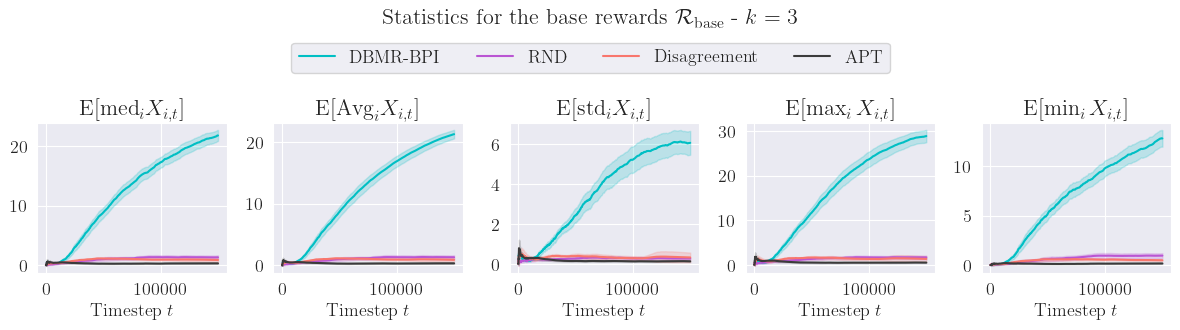

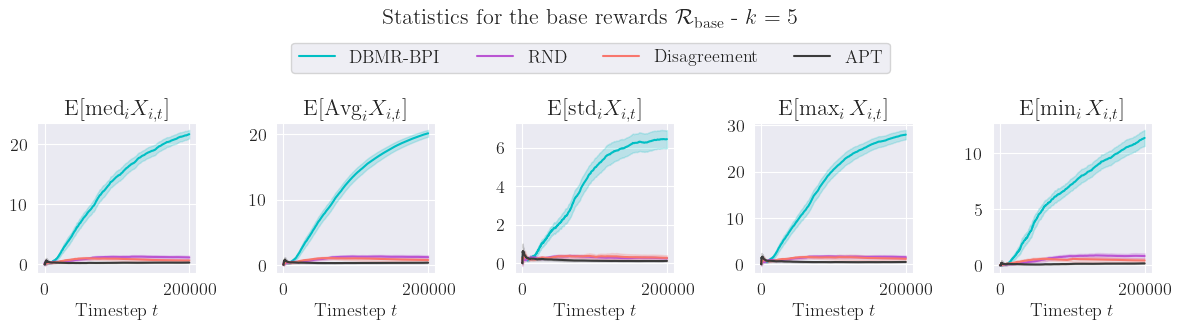

In [11]:
sns.set_style("darkgrid", rc=rc_parameters)
def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = tstudent.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)

functions=  [('Median', lambda x,axis: np.median(x, axis=axis)),('Avg', np.mean),  ('STD', np.std), ('Max', np.max), ('Min', np.min)]


def downsample(data, factor):
    return data[::factor]

downsample_factor = 50  # To reduce the size of the plot
for size, num_step in num_steps:
    fig, ax = plt.subplots(1, 5, figsize=(12, 3))
    agents_ids = {
        agent: agent_id for agent_id, agent in enumerate(df_grouped[(size, num_step)].index.get_level_values(0).unique())
    }
    for agent in ordered_agents:
        agent_id = agents_ids[agent]
        if agent == 'MR-BSP': continue
        for axid, (func_name, func) in enumerate(functions):
            T = 1 + np.array(df_grouped[(size, num_step)].index.get_level_values(2).unique()) if func_name != 'isclose' else np.array([1])
            plot_data = func(df_numpy[(size, num_step)][agent_id][..., :num_base_rew] / T[None, :, None], axis=-1)
            plot_data_mu = plot_data.mean(0)

            mu, ce = CE(plot_data)

            # Downsample the data to reduce image size
            mu = downsample(mu, downsample_factor)
            ce = downsample(ce, downsample_factor)
            ce_low, ce_high = mu - ce, mu + ce
            x_points = downsample(np.arange(plot_data.shape[1]), downsample_factor)

            mu = mu if func_name == 'isclose' else mu * 100
            ce_low = ce_low if func_name == 'isclose' else ce_low * 100
            ce_high = ce_high if func_name == 'isclose' else ce_high * 100
            ax[axid].plot(x_points, mu, label=labels_agents[agent], color=colors[agent])
            ax[axid].fill_between(x_points, ce_low, ce_high, alpha=0.2, color=colors[agent])

            if func_name == 'Max':
                ax[axid].set_title(r'$\mathrm{E}[\max_i X_{i,t}]$')
            elif func_name == 'Min':
                ax[axid].set_title(r'${\rm E}[\min_i X_{i,t}]$')
            elif func_name == 'STD':
                ax[axid].set_title(r'${\rm E}[{\rm std}_i X_{i,t}]$')
            elif func_name == 'Median':
                ax[axid].set_title(r'${\rm E}[{\rm med}_i X_{i,t}]$')
            elif func_name == 'isclose':
                ax[axid].set_title(r'${\rm E}[\sum_{i} \mathbf{1}_{X_{i,t} = 0}]$')
            elif func_name == 'Avg':
                ax[axid].set_title(r'${\rm E}[{\rm Avg}_i X_{i,t}]$')
            ax[axid].set_xlabel('Timestep $t$')
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), frameon=True, ncols=4)
    plt.suptitle(r'Statistics for the base rewards ${\cal R}_{\rm base}$' + f' - $k={size}$', y=1.1)
    fig.tight_layout()
    plt.savefig(f'figures/Cartpole/base_rew_size_{size}.pdf', bbox_inches='tight')
    plt.show()


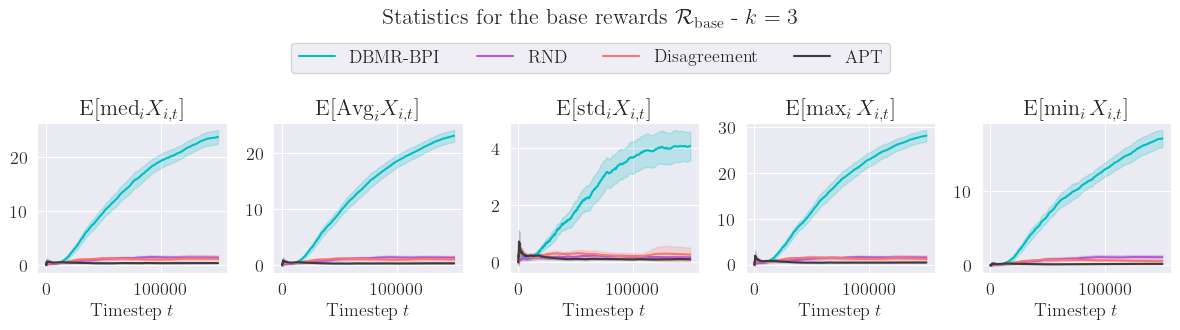

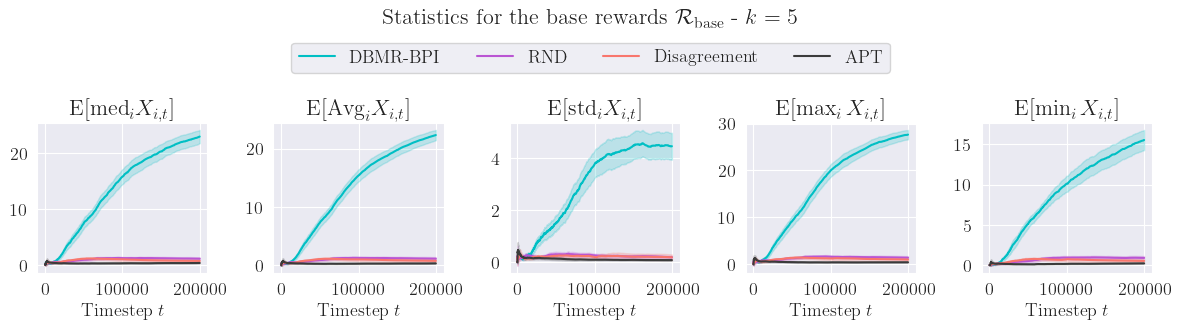

In [12]:
sns.set_style("darkgrid", rc=rc_parameters)


functions=  [('Median', lambda x,axis: np.median(x, axis=axis)),('Avg', np.mean),  ('STD', np.std), ('Max', np.max), ('Min', np.min)]

for size, num_step in num_steps:
    fig, ax = plt.subplots(1, 5, figsize=(12,3))
    agents_ids = {
        agent: agent_id for agent_id, agent in enumerate(df_grouped[(size, num_step)].index.get_level_values(0).unique())
    }
    for agent in ordered_agents:
        agent_id = agents_ids[agent]
        if agent == 'MR-BSP': continue
        for axid, (func_name, func) in enumerate(functions):
            T = 1+np.array(df_grouped[(size, num_step)].index.get_level_values(2).unique()) if func_name != 'isclose' else np.array([1])
            plot_data = func(df_numpy[(size, num_step)][agent_id][...,num_base_rew:]/T[None,:, None], axis=-1)#.max(-1)#.mean(0)
            plot_data_mu = plot_data.mean(0)

            mu, ce = CE(plot_data)

            # Downsample the data
            mu = downsample(mu, downsample_factor)
            ce = downsample(ce, downsample_factor)
            ce_low, ce_high = mu - ce, mu + ce
            x_points = downsample(np.arange(plot_data.shape[1]), downsample_factor)

            mu = mu if func_name == 'isclose' else mu * 100
            ce_low = ce_low if func_name == 'isclose' else ce_low * 100
            ce_high = ce_high if func_name == 'isclose' else ce_high * 100
            ax[axid].plot(x_points, mu, label=labels_agents[agent], color=colors[agent])
            ax[axid].fill_between(x_points, ce_low, ce_high, alpha=0.2, color=colors[agent])
            if func_name == 'Max':
                ax[axid].set_title(r'$\mathrm{E}[\max_i X_{i,t}]$')
            elif func_name == 'Min':
                ax[axid].set_title(r'${\rm E}[\min_i X_{i,t}]$')
            elif func_name == 'STD':
                ax[axid].set_title(r'${\rm E}[{\rm std}_i X_{i,t}]$')
            elif func_name == 'Median':
                ax[axid].set_title(r'${\rm E}[{\rm med}_i X_{i,t}]$')
            elif func_name == 'isclose':
                ax[axid].set_title(r'${\rm E}[\sum_{i} \mathbf{1}_{X_{i,t} = 0}]$')
            elif func_name == 'Avg':
                ax[axid].set_title(r'${\rm E}[{\rm Avg}_i X_{i,t}]$')

            ax[axid].set_xlabel('Timestep $t$')
    handles, labels = ax[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), frameon=True, ncols=4)
    plt.suptitle(r'Statistics for the base rewards ${\cal R}_{\rm base}$' + f' - $k={size}$', y=1.1)
    fig.tight_layout()
    plt.savefig(f'figures/Cartpole/rnd_rew_size_{size}.pdf', bbox_inches='tight')
    plt.show()

In [13]:
import lzma
import pickle
from typing import NamedTuple
num_steps = [(3,150000), (5, 200000)]
num_seeds = 30
seeds = [x for x in range(num_seeds)]
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

dfs = {}


for size, num_step in num_steps:
    path = 'data/CartpoleSwingup/{}/'.format(num_step)
    data = []
    history_chosen_rewards = []
    history_delta_min = []
    min_size = np.infty
    for seed in seeds:
        with lzma.open(f'{path}/DBMR-BPI_{seed}_info.pkl.lzma', 'rb') as f:
            data_info = pickle.load(f)

        history_chosen_rewards.append(np.array(data_info['history_chosen_rewards']))
        history_delta_min.append(data_info['history_delta_min'])
        min_size = min(min_size, len(history_chosen_rewards[-1]))

  

    history_chosen_rewards = [x[:min_size] for x in history_chosen_rewards]

    dfs[(size, num_step)] = {'history_chosen_rewards': np.array(history_chosen_rewards),
                             'history_delta_min': np.array(history_delta_min)}

<Figure size 640x480 with 0 Axes>

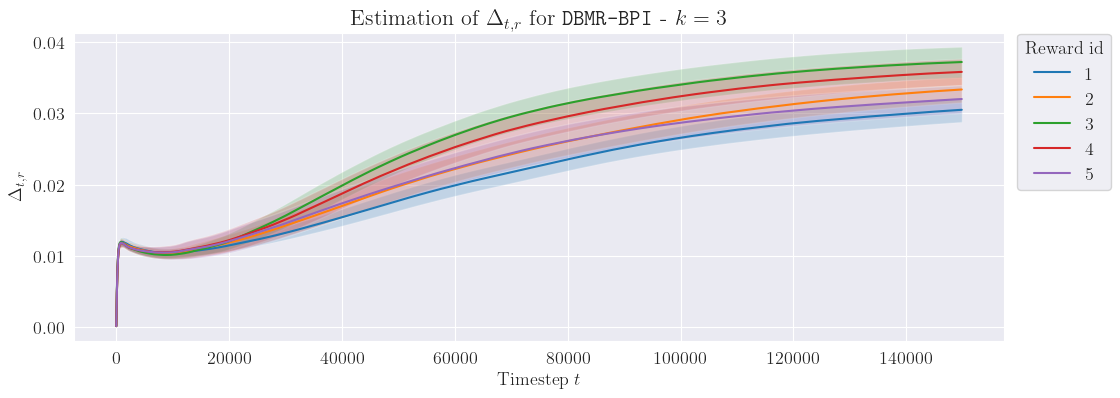

<Figure size 640x480 with 0 Axes>

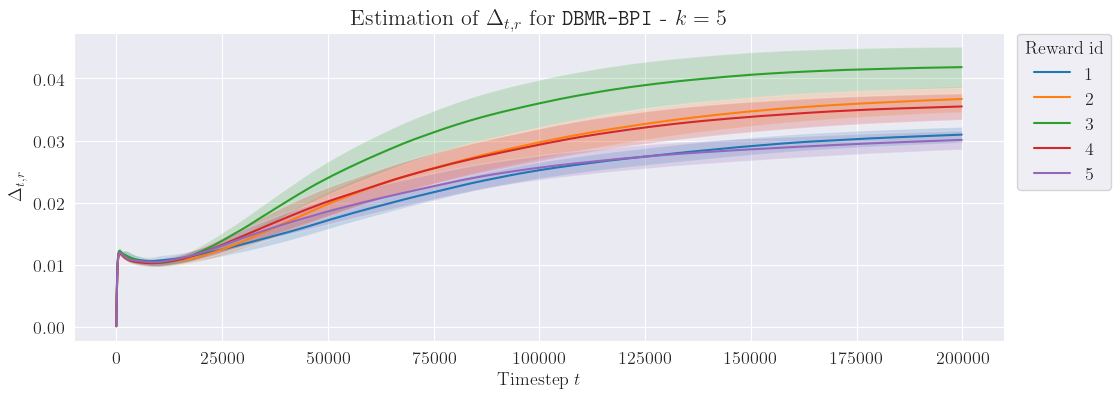

In [14]:
for size, num_step in num_steps:
    plt.figure()
    x = dfs[(size, num_step)]

    


    fig, ax = plt.subplots(1,1, figsize=(12,4))
    for i in range(num_base_rew):
        xmin = np.cumsum(x['history_delta_min'][..., i], axis=1) / (1+np.arange(x['history_delta_min'].shape[1]))[None,:]
        xmean, xce = CE(xmin)
        
        num_step_x = xmean.shape[0]
        xmean = downsample(xmean, downsample_factor)
        xce = downsample(xce, downsample_factor)
        xrange = downsample(np.arange(num_step_x), downsample_factor)
        ax.plot(xrange,xmean, label=f'{i+1}')
        
        ax.fill_between(xrange, xmean-xce, xmean+xce, alpha=0.2)
        
    plt.xlabel(r'Timestep $t$')
    plt.ylabel(r'$\Delta_{t,r}$')
    handles, labels = ax.get_legend_handles_labels()
    plt.title(r'Estimation of $\Delta_{t,r}$ for {\tt DBMR-BPI}' + f' - $k={size}$')
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(.95, 0.9), frameon=True, ncols=1, title='Reward id')
    plt.savefig(f'figures/Cartpole/delta_min_{size}.pdf', bbox_inches='tight')
    plt.show()

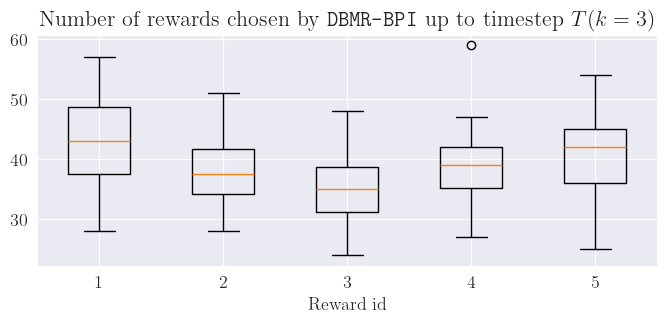

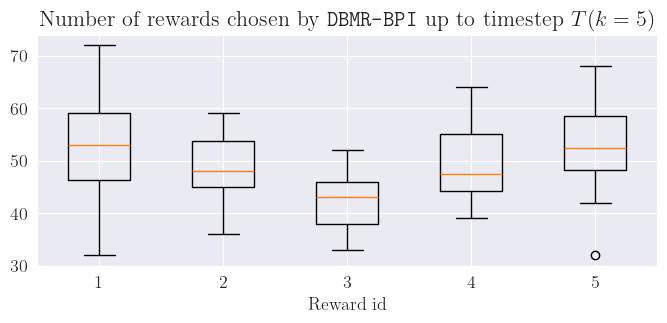

In [ ]:
for size, num_step in num_steps:
    x = dfs[(size, num_step)]
    Xnew = np.eye(num_base_rew)[x['history_chosen_rewards']]
    Xnew = Xnew.cumsum(axis=1)
    fig, ax = plt.subplots(1,1, figsize=(8,3))

    ax.boxplot(Xnew[:,-1])
    ax.set_xlabel('Reward id')
    ax.set_title(r'Number of rewards chosen by {\tt DBMR-BPI} up to timestep $T$' + f'($k={size}$)')
    plt.savefig(f'figures/Cartpole/num_rew_chosen_{size}.pdf', bbox_inches='tight')
    plt.show()
